# Predicting the price of a stock using Machine Learning Algorithms

The goal of this project is to use a variety of past data about lots of stocks on the US New York Stock Exchange in order to be able to predict their future price. The results of this model could, for example, be combined with those of other analyses, perhaps by human analysts, to determine the investing strategy of a financial enterprise. For example, if our model predicted a price different to the actual price of a stock on the market, this could suggest that the stock is either undervalued or overvalued, and help a company cash in before a bubble bursts or jump onto a promising stock before the rest of the market realizes its potential - either way benefitting.


# Overview

The project will have the following structure

* Problem Definition
* Imports and Functions
* Data (importing and exploring)
* Training models
* Improving the models
* Evaluating the models
* Investigating the importance of the various features of the data
* Conclusion

# 1. Problem Definition

This is a regression problem, so we will be testing out a few different regression ML models, and seeing which one performs the best. The idea behind this project is for the model to go over many of the metrics of the fundamental value of a stock, and from this attempt to predict what its price will be in the future. This is very much a fundamentalist approach to stock analysis - looking at various metrics about the company and trying to extrapolate from there, as opposed to ideas like momentum investing or even a chartist approach. However, in the long term, fundamentals are likely to win out over these methods, which are by their nature more short term and better for high-frequency day traders. 

# 2. Imports and Functions

## 2.1. Imports

Here, we are first going to import all the useful packages we will probably need during this project

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

## 2.2. Functions

There are probably going to be things we do multiple times over the course of this project. Rather than rewriting the code, I thought it made sense to create a section for functions right at the top. This will save us a lot of time not having to rewrite code, and having all the functions in one place at the top of the notebook means they can be easily accessed and consulted.

This first function lets us quickly evaluate our model on two common metrics

In [96]:
def show_scores(model, X_train, X_val, y_train, y_val):
    # predict on train and validation data
    train_predictions = model.predict(X_train)
    val_predictions = model.predict(X_val)
    # return a dictionary comparing predictions and true values
    scores = {"Training RMSE": mean_squared_error(y_train, train_predictions, squared=False),
              "Valid RMSE": mean_squared_error(y_val, val_predictions, squared=False),
              "Training R^2": r2_score(y_train, train_predictions),
              "Valid R^2": r2_score(y_val, val_predictions)}
    return scores

This function plots our feature importances.

In [163]:
def plot_features(columns, importances, n=10): # only plot top ten features
    # create a dataframe to plot
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          # sort in order of importance
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    # a horizontal bar chart is more visual and easy to understand here
    ax.barh(df["features"][:n], df["feature_importances"][:10])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

# 3. Data

## 3.1. Importing Data

The data used is imported from Kaggle - https://www.kaggle.com/dgawlik/nyse. 
This data is for the New York Stock Exchange, and consists of three datasets - fundamental value metrics, prices and volume, and ticker explanations. We will train our model on the fundamentals dataset. Companies generally release all this data around the same time each year, so we will add a target column to our fundamentals dataset that gives the price from the year the fundamental data was obtained. This will allow us to judge whether our model is accurately predicting price from fundamentals. 

In [2]:
# Import fundamentals dataset
fundamentals_original = pd.read_csv("fundamentals.csv", parse_dates=["Period Ending"])

# Let's create a copy to tweak and adjust, so that we don't have to reimport if things go wrong
fundamentals = fundamentals_original.copy()

# Import prices dataset
prices_original = pd.read_csv("prices-split-adjusted.csv")

# Do the same thing for the prices
prices = prices_original.copy()

So since we have some time series data, let's sort the datasets by date

In [3]:
fundamentals.sort_values(by="Ticker Symbol", inplace=True, ascending=True)
fundamentals[:20]

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-2.220000e+08,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-3.670000e+08,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-9.300000e+07,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.000000e+00,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-1.600000e+08,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.000000e+00,2014.0,4.02,7.169154e+08
3,3,AAL,2015-12-31,5.102000e+09,3.520000e+08,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.000000e+00,2015.0,11.39,6.681299e+08
4,4,AAP,2012-12-29,2.409453e+09,-8.948200e+07,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-2.709500e+07,2012.0,5.29,7.328355e+07
5,5,AAP,2013-12-28,2.609239e+09,-3.242800e+07,2.698000e+06,26.0,-1.957570e+08,5.312930e+08,40.0,...,3.989384e+09,2.764785e+09,1.516205e+09,4.048569e+09,5.564774e+09,6.493814e+09,-1.078900e+08,2013.0,5.36,7.308918e+07
6,6,AAP,2015-01-03,3.616038e+09,-4.820900e+07,3.092000e+06,25.0,-2.284460e+08,5.629450e+08,3.0,...,4.741040e+09,3.654416e+09,2.002912e+09,5.959446e+09,7.962358e+09,9.843861e+09,-1.130440e+08,2014.0,6.75,7.315926e+07
7,7,AAP,2016-01-02,3.757085e+09,-2.147600e+07,-7.484000e+06,19.0,-2.347470e+08,6.033320e+08,2.0,...,4.940746e+09,3.797477e+09,2.460648e+09,5.673917e+09,8.134565e+09,9.737018e+09,-1.197090e+08,2015.0,6.45,7.339504e+07
8,8,AAPL,2013-09-28,3.622300e+10,-1.949000e+09,1.156000e+09,30.0,-8.165000e+09,0.000000e+00,93.0,...,7.328600e+10,4.365800e+10,1.235490e+11,8.345100e+10,2.070000e+11,1.709100e+11,0.000000e+00,2013.0,40.03,9.252311e+08
9,9,AAPL,2014-09-27,4.864900e+10,-6.452000e+09,9.800000e+08,35.0,-9.571000e+09,0.000000e+00,40.0,...,6.853100e+10,6.344800e+10,1.115470e+11,1.202920e+11,2.318390e+11,1.827950e+11,0.000000e+00,2014.0,6.49,6.087827e+09


In [4]:
prices.sort_values(by="symbol",inplace=True,ascending=True)
prices[:20]

,date,symbol,open,close,low,high,volume
85998,2010-09-24,A,22.153077,22.954220,22.153077,23.004292,5083900.0
563193,2014-09-15,A,41.845494,41.430614,41.301861,41.845494,2266200.0
796764,2016-07-28,A,47.189999,47.509998,47.020000,47.750000,1944800.0
183719,2011-07-22,A,33.583691,33.540772,33.276108,33.719601,2894100.0
24586,2010-03-19,A,23.905579,23.905579,23.698141,24.077253,5882500.0
810764,2016-09-07,A,47.070000,47.110001,46.860001,47.169998,1542400.0
749342,2016-03-14,A,38.980000,39.020000,38.410000,39.169998,929600.0
64893,2010-07-22,A,19.992848,20.543634,19.992848,20.650931,5102000.0
288059,2012-06-08,A,28.340486,28.326180,28.204579,28.505007,4244600.0
405612,2013-06-05,A,32.417740,31.852646,31.831188,32.460659,3488100.0


In [5]:
fundamentals.shape

(1781, 79)

In [6]:
prices.shape

(851264, 7)

Clearly, we have many more prices than we do items of fundamental data. But we don't actually want all of these prices, as they are day to day. What we want is for each row in the fundamentals dataset, the price of that stock at the date the fundamental data was recorded (i.e. the end of their financial year/quarter)

In [36]:
# our dates are currently timestamps, so we want to remove the time (not the date) and convert to datetime
# we create two temporary dataframes to allow us to do this
df = pd.DataFrame()
df2 = pd.DataFrame()
# convert the timestamp in fundamentals to a datetime
df["temp"] = pd.to_datetime(fundamentals['Period Ending'], format='%Y-%m-%d')
# convert that datetime into just a date
fundamentals["Time Period Ending"] = df["temp"].dt.date
# basically the same process
df2['othertemp'] = pd.to_datetime(prices['date'])
prices["date"] = df2["othertemp"].dt.date
# And down here we finally create two lists of corresponding dates and symbols
symbols = [symbol for symbol in fundamentals["Ticker Symbol"]]
dates = [date for date in fundamentals["Time Period Ending"]]

In [41]:
# This cell is simply to test the code in the cell below, as the loop in the cell below takes a little while to run, and we want to be sure we aren't making a mistake before we run it.
array = []
test = prices.loc[(prices["date"]==dates[1400]) & (prices["symbol"]==symbols[1400])].index.to_numpy()
#symbols[1400]
#dates[1400]
#test[0]
array.append(prices["close"][test[0]])
array


[34.049999]

In [42]:
# empty array to hold our prices
corresponding_prices = []
# our date and symbol lists are exactly the same length, and their elements correspond, so we can use i in both lists
for i in range(len(dates)):
    # we are using a try catch because some rows don't have data, and this throws an error
    try:
        # find the location in prices where the date and symbol match our desired date and symbol, and make it a numpy array
        index = prices.loc[(prices["date"]==dates[i]) & (prices["symbol"]==symbols[i])].index.to_numpy()
        corresponding_prices.append(prices["close"][index[0]])
    # if we can't find the price, say it's 0 - we will remove these rows later as without a price, they are meaningless to us
    except:
        corresponding_prices.append(0)
# Test if it's got the correct prices
corresponding_prices[1400]

34.049999

In [43]:
fundamentals["Target"] = corresponding_prices
fundamentals[10:20]

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding,Time Period Ending,Target
10,10,AAPL,2015-09-26,6.067100e+10,-3.124000e+09,1.285000e+09,45.0,-1.124700e+10,0.000000e+00,52.0,...,1.193550e+11,1.709900e+11,2.903450e+11,2.337150e+11,0.000000e+00,2015.0,9.28,5.753664e+09,2015-09-26,0.000000
11,11,AAPL,2016-09-24,5.932100e+10,1.044000e+09,1.348000e+09,36.0,-1.273400e+10,0.000000e+00,85.0,...,1.282490e+11,1.934370e+11,3.216860e+11,2.156390e+11,0.000000e+00,2016.0,8.35,5.471497e+09,2016-09-24,0.000000
15,15,ABBV,2015-12-31,8.463000e+09,-1.076000e+09,-2.060000e+08,130.0,-5.320000e+08,1.308000e+10,77.0,...,3.945000e+09,4.910500e+10,5.305000e+10,2.285900e+10,-8.839000e+09,2015.0,3.15,1.633016e+09,2015-12-31,59.240002
14,14,ABBV,2014-12-31,6.954000e+09,-1.720000e+08,-6.510000e+08,102.0,-6.120000e+08,4.194000e+09,74.0,...,1.742000e+09,2.577100e+10,2.751300e+10,1.996000e+10,-9.720000e+08,2014.0,1.11,1.598198e+09,2014-12-31,65.440002
12,12,ABBV,2012-12-31,5.734000e+09,2.230000e+08,-8.000000e+06,1507.0,-3.330000e+08,0.000000e+00,118.0,...,-3.500000e+08,2.735800e+10,2.700800e+10,1.838000e+10,0.000000e+00,NaN,NaN,NaN,2012-12-31,0.000000
13,13,ABBV,2013-12-31,6.448000e+09,6.810000e+08,-5.400000e+07,92.0,-4.910000e+08,3.671000e+09,144.0,...,4.492000e+09,2.470600e+10,2.919800e+10,1.879000e+10,-3.200000e+08,2013.0,2.58,1.600000e+09,2013-12-31,52.810001
16,16,ABC,2013-09-30,1.487064e+10,-2.312518e+09,-4.400000e+04,19.0,-2.024500e+08,2.360992e+09,8.0,...,2.319745e+09,1.659889e+10,1.891864e+10,8.795917e+10,-1.516856e+09,2013.0,1.88,2.306952e+08,2013-09-30,61.099998
17,17,ABC,2014-09-30,1.725016e+10,-9.382860e+08,-2.859400e+07,14.0,-2.644570e+08,2.749185e+09,10.0,...,1.956899e+09,1.957528e+10,2.153218e+10,1.195691e+11,-2.313380e+09,2014.0,1.22,2.247787e+08,2014-09-30,77.300003
18,18,ABC,2015-09-30,2.157823e+10,-1.478793e+09,-4.422000e+07,22.0,-2.315850e+08,3.736477e+09,10.0,...,6.163860e+08,2.734660e+10,2.796298e+10,1.359618e+11,-4.150997e+09,2015.0,-0.62,2.228468e+08,2015-09-30,94.989998
19,19,ABC,2016-09-30,2.467016e+10,-9.127240e+08,5.048000e+06,67.0,-4.646160e+08,4.333001e+09,11.0,...,2.129404e+09,3.152680e+10,3.365620e+10,1.468497e+11,-4.396008e+09,2016.0,6.73,2.121737e+08,2016-09-30,80.779999


## 3.2. Cleaning Data

In order to be able to train a machine learning model on this data, we first need to get it all into numerical form. This involves imputing missing values or deleting rows if there is insufficient data, making sure the data is all of a consistent shape, and so on.

In [53]:
# Let's first get rid of any rows where the price is 0 (i.e. there was no data for it)
fundamentals.drop(fundamentals[fundamentals.Target == 0].index, inplace=True)
# we also drop this unnamed column - its purpose is unclear and its certainly not measuring anything about the company, so we get rid of it
fundamentals.drop("Unnamed: 0", axis=1, inplace=True)
# we now have two columns with the same data, just in different formats, so we can drop the period ending column
fundamentals.drop("Period Ending", axis=1, inplace=True)

In [54]:
fundamentals[:10]

,Ticker Symbol,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,...,Earnings Per Share,Estimated Shares Outstanding,Time Period Ending,Target,Cash Ratio_is_missing,Current Ratio_is_missing,Quick Ratio_is_missing,For Year_is_missing,Earnings Per Share_is_missing,Estimated Shares Outstanding_is_missing
0,AAL,3.068000e+09,-2.220000e+08,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.000000e+00,...,-5.60,3.350000e+08,2012-12-31,13.500000,False,False,False,False,False,False
1,AAL,4.975000e+09,-9.300000e+07,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.000000e+00,...,-11.25,1.630222e+08,2013-12-31,25.250000,False,False,False,False,False,False
2,AAL,4.668000e+09,-1.600000e+08,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.000000e+00,...,4.02,7.169154e+08,2014-12-31,53.630001,False,False,False,False,False,False
3,AAL,5.102000e+09,3.520000e+08,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,0.000000e+00,...,11.39,6.681299e+08,2015-12-31,42.349998,False,False,False,False,False,False
15,ABBV,8.463000e+09,-1.076000e+09,-2.060000e+08,130.0,-5.320000e+08,1.308000e+10,77.0,8.399000e+09,-4.340000e+08,...,3.15,1.633016e+09,2015-12-31,59.240002,False,False,False,False,False,False
14,ABBV,6.954000e+09,-1.720000e+08,-6.510000e+08,102.0,-6.120000e+08,4.194000e+09,74.0,8.348000e+09,-2.030000e+08,...,1.11,1.598198e+09,2014-12-31,65.440002,False,False,False,False,False,False
13,ABBV,6.448000e+09,6.810000e+08,-5.400000e+07,92.0,-4.910000e+08,3.671000e+09,144.0,9.595000e+09,-5.600000e+07,...,2.58,1.600000e+09,2013-12-31,52.810001,False,False,False,False,False,False
16,ABC,1.487064e+10,-2.312518e+09,-4.400000e+04,19.0,-2.024500e+08,2.360992e+09,8.0,1.231006e+09,-1.486572e+09,...,1.88,2.306952e+08,2013-09-30,61.099998,False,False,False,False,False,False
17,ABC,1.725016e+10,-9.382860e+08,-2.859400e+07,14.0,-2.644570e+08,2.749185e+09,10.0,1.808513e+09,-1.304569e+09,...,1.22,2.247787e+08,2014-09-30,77.300003,False,False,False,False,False,False
18,ABC,2.157823e+10,-1.478793e+09,-4.422000e+07,22.0,-2.315850e+08,3.736477e+09,10.0,2.167442e+09,-1.379189e+09,...,-0.62,2.228468e+08,2015-09-30,94.989998,False,False,False,False,False,False


Now our dataset has the target price column all filled. However, there might be some missing data in the rest of the columns, which we may need to fill in. Let's investigate this further...

In [55]:
fundamentals.isna().sum()

Ticker Symbol                              0
Accounts Payable                           0
Accounts Receivable                        0
Add'l income/expense items                 0
After Tax ROE                              0
                                          ..
Current Ratio_is_missing                   0
Quick Ratio_is_missing                     0
For Year_is_missing                        0
Earnings Per Share_is_missing              0
Estimated Shares Outstanding_is_missing    0
Length: 85, dtype: int64

In [56]:
# Let's investigate which of our data is currently numeric
for label, content in fundamentals.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

Accounts Payable
Accounts Receivable
Add'l income/expense items
After Tax ROE
Capital Expenditures
Capital Surplus
Cash Ratio
Cash and Cash Equivalents
Changes in Inventories
Common Stocks
Cost of Revenue
Current Ratio
Deferred Asset Charges
Deferred Liability Charges
Depreciation
Earnings Before Interest and Tax
Earnings Before Tax
Effect of Exchange Rate
Equity Earnings/Loss Unconsolidated Subsidiary
Fixed Assets
Goodwill
Gross Margin
Gross Profit
Income Tax
Intangible Assets
Interest Expense
Inventory
Investments
Liabilities
Long-Term Debt
Long-Term Investments
Minority Interest
Misc. Stocks
Net Borrowings
Net Cash Flow
Net Cash Flow-Operating
Net Cash Flows-Financing
Net Cash Flows-Investing
Net Income
Net Income Adjustments
Net Income Applicable to Common Shareholders
Net Income-Cont. Operations
Net Receivables
Non-Recurring Items
Operating Income
Operating Margin
Other Assets
Other Current Assets
Other Current Liabilities
Other Equity
Other Financing Activities
Other Investing Ac

In [58]:
# Let's check which numeric columns have missing data
for label, content in fundamentals.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

Our dataframe is already a little short - only about 1350 rows after deleting the rows missing a price attribute, so simply removing all these rows where there is no data is probably not going to leave us very much data. Instead, we might as well fill these missing data with the medians of their respective columns - there is a large diversity of companies (big and small) on the NYSE, so taking the median should give us a decent estimate for all of these parameters. Let's implement this filling in the next cell.

In [49]:
# Fill numeric rows with the median
for label, content in fundamentals.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing or not
            fundamentals[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            fundamentals[label] = content.fillna(content.median())

In [59]:
# Let's check which numeric columns have missing data
for label, content in fundamentals.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

This is great, no output from the previous cell means none of our numeric columns have any missing data anymore. Time to investigate any non-numeric columns, and fill them in too.

In [60]:
fundamentals.isna().sum()

Ticker Symbol                              0
Accounts Payable                           0
Accounts Receivable                        0
Add'l income/expense items                 0
After Tax ROE                              0
                                          ..
Current Ratio_is_missing                   0
Quick Ratio_is_missing                     0
For Year_is_missing                        0
Earnings Per Share_is_missing              0
Estimated Shares Outstanding_is_missing    0
Length: 85, dtype: int64

In [61]:
# Check for columns which aren't numeric
for label, content in fundamentals.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

Ticker Symbol
Time Period Ending


As we can see above, all the ticker symbols and time period ending are filled with data. Every other column is numeric, and there are no missing numeric values. This is amazing - our dataframe now has no missing values at all. However, our model will not be able to train if there are some non numerical columns. Our next step, therefore, is to convert ticker symbol and time period ending into numbers.

In [67]:
fundamentals["Time Period Ending"].head()

0     2012-12-31
1     2013-12-31
2     2014-12-31
3     2015-12-31
15    2015-12-31
Name: Time Period Ending, dtype: object

 Let's first fix the Time Period Ending column

In [72]:
# we convert it to pandas datetime format so we can call some useful methods on it
fundamentals["Time Period Ending"] = pd.to_datetime(fundamentals["Time Period Ending"])

In [73]:
# we split the date of period ending into three separate numbers we can put in different columns
fundamentals["Period Ending Year"] = fundamentals["Time Period Ending"].dt.year
fundamentals["Period Ending Month"] = fundamentals["Time Period Ending"].dt.month
fundamentals["Period Ending Day"] = fundamentals["Time Period Ending"].dt.day

In [74]:
fundamentals.head()

,Ticker Symbol,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,...,Target,Cash Ratio_is_missing,Current Ratio_is_missing,Quick Ratio_is_missing,For Year_is_missing,Earnings Per Share_is_missing,Estimated Shares Outstanding_is_missing,Period Ending Year,Period Ending Month,Period Ending Day
0,AAL,3.068000e+09,-2.220000e+08,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,...,13.500000,False,False,False,False,False,False,2012,12,31
1,AAL,4.975000e+09,-9.300000e+07,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,...,25.250000,False,False,False,False,False,False,2013,12,31
2,AAL,4.668000e+09,-1.600000e+08,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,...,53.630001,False,False,False,False,False,False,2014,12,31
3,AAL,5.102000e+09,3.520000e+08,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,0.0,...,42.349998,False,False,False,False,False,False,2015,12,31
15,ABBV,8.463000e+09,-1.076000e+09,-2.060000e+08,130.0,-5.320000e+08,1.308000e+10,77.0,8.399000e+09,-434000000.0,...,59.240002,False,False,False,False,False,False,2015,12,31


Now we have all the Time Period Ending Data in various columns, we can get rid of the original column

In [75]:
fundamentals.drop("Time Period Ending", axis=1, inplace=True)

In [76]:
fundamentals.head()

,Ticker Symbol,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,...,Target,Cash Ratio_is_missing,Current Ratio_is_missing,Quick Ratio_is_missing,For Year_is_missing,Earnings Per Share_is_missing,Estimated Shares Outstanding_is_missing,Period Ending Year,Period Ending Month,Period Ending Day
0,AAL,3.068000e+09,-2.220000e+08,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,...,13.500000,False,False,False,False,False,False,2012,12,31
1,AAL,4.975000e+09,-9.300000e+07,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,...,25.250000,False,False,False,False,False,False,2013,12,31
2,AAL,4.668000e+09,-1.600000e+08,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,...,53.630001,False,False,False,False,False,False,2014,12,31
3,AAL,5.102000e+09,3.520000e+08,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,0.0,...,42.349998,False,False,False,False,False,False,2015,12,31
15,ABBV,8.463000e+09,-1.076000e+09,-2.060000e+08,130.0,-5.320000e+08,1.308000e+10,77.0,8.399000e+09,-434000000.0,...,59.240002,False,False,False,False,False,False,2015,12,31


Now we have to convert our ticker symbols to numeric

In [77]:
# Turn categorical variables into numbers and fill missing
for label, content in fundamentals.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Turn categories into numbers and add +1
        fundamentals[label] = pd.Categorical(content).codes+1

In [78]:
# Find the columns which contain strings
for label, content in fundamentals.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

In [79]:
fundamentals.head()

,Ticker Symbol,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,...,Target,Cash Ratio_is_missing,Current Ratio_is_missing,Quick Ratio_is_missing,For Year_is_missing,Earnings Per Share_is_missing,Estimated Shares Outstanding_is_missing,Period Ending Year,Period Ending Month,Period Ending Day
0,1,3.068000e+09,-2.220000e+08,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,...,13.500000,False,False,False,False,False,False,2012,12,31
1,1,4.975000e+09,-9.300000e+07,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,...,25.250000,False,False,False,False,False,False,2013,12,31
2,1,4.668000e+09,-1.600000e+08,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,...,53.630001,False,False,False,False,False,False,2014,12,31
3,1,5.102000e+09,3.520000e+08,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,0.0,...,42.349998,False,False,False,False,False,False,2015,12,31
15,2,8.463000e+09,-1.076000e+09,-2.060000e+08,130.0,-5.320000e+08,1.308000e+10,77.0,8.399000e+09,-434000000.0,...,59.240002,False,False,False,False,False,False,2015,12,31


This is great, now even our ticker symbols are converted to categorical codes which are numbers instead of symbols. Before we dive into some exploratory data analysis, let's just run a couple of final checks to ensure our data is now in a form that a machine learning model can train on.

In [80]:
fundamentals.isna().any()

Ticker Symbol                              False
Accounts Payable                           False
Accounts Receivable                        False
Add'l income/expense items                 False
After Tax ROE                              False
                                           ...  
Earnings Per Share_is_missing              False
Estimated Shares Outstanding_is_missing    False
Period Ending Year                         False
Period Ending Month                        False
Period Ending Day                          False
Length: 87, dtype: bool

In [81]:
# Check if there are any non numeric columns left
for label, content in fundamentals.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Turn categories into numbers and add +1
        print(label)

So it looks like all our columns are full, and full of numeric data. This is great, as it means we have finished cleaning and organizing our dataset. Before we start training our model, it's worth exploring the data a little to get a feel for how it works, so let's do that now

## 3.3. Data Exploration

Now that we have our data in a pandas DataFrame, it is probably worth doing some data exploration before we dive into modeling. This will give us a feel for the data and perhaps highlight some insights into general trends within the data. This may later help us identify if our model seems to be making peculiar predictions, as well as showing any potential outliers we might need to discard. Additionally, it's always good to have some idea of how the data works and what it looks like, so that we are not simply placing blind faith in a black box regression model and hoping its results are always right. There's 84 columns, so we obviously cannot plot them all, but it's worth exploring at least some of them.

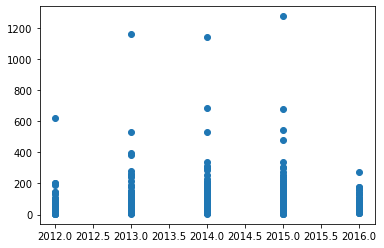

In [83]:
fig, ax = plt.subplots()
ax.scatter(fundamentals["Period Ending Year"][:1000], fundamentals["Target"][:1000]);

There doesn't seem to be a particularly strong connection between the year and stock prices - although 2016 looks bad, that could simply be no data being available for the very expensive companies that year. This might hint at little overall trend in the stock market, which would make sense - it's not as though the market inexorably rises with the passage of time, but tends to fluctuate.

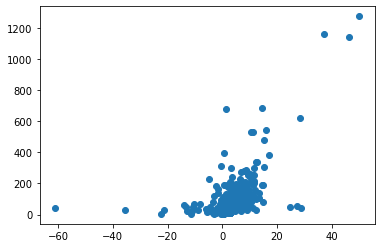

In [84]:
fig, ax = plt.subplots()
ax.scatter(fundamentals["Earnings Per Share"][:1000], fundamentals["Target"][:1000]);

This cell, on the other hand, shows something of a positive correlation. It's not the strongest you'll ever see, because analysts and human evaluators of stocks are inherently subjective and varying in their assessments of the worth of a stock, but there does seem to be some sort of positive correlation - evidently, delivering higher earnings per share gives you a higher stock price, which intuitively seems to make sense. 

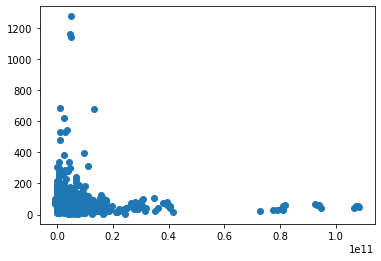

In [85]:
fig, ax = plt.subplots()
ax.scatter(fundamentals["Capital Surplus"][:1000], fundamentals["Target"][:1000]);

This is interesting - there appears to not be a great deal of correlation - if anything a very slight negative one - between capital surplus and price. You might be surprised that a company with a large surplus would not be highly valued, but perhaps investors are disappointed that the company is not reinvesting the money and using to drive growth. This is probably an instance where an intuitive explanation is unlikely to suffice, and we should ask a financial expert if they could shine some light on this trend.

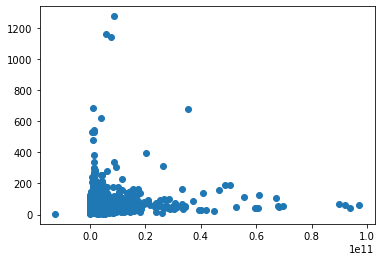

In [86]:
fig, ax = plt.subplots()
ax.scatter(fundamentals["Gross Profit"][:1000], fundamentals["Target"][:1000]);

Again very interesting - you might intuitively expect a strong positive correlation, but in fact the data is less supportive of this claim. Again, we might want to speak to a finance professional, but this data analysis is very useful - it shows us that our assumptions about how various factors influence stock price may well be wrong.

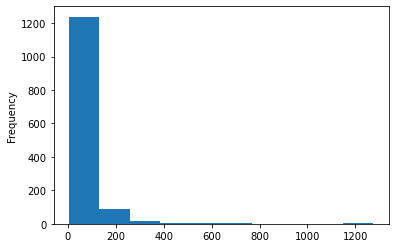

In [87]:
fundamentals.Target.plot.hist();

This is a rather sharp histogram - it seems that the vast majority of stocks are between 0 and 150 dollars, with extremely few above even 200. This is likely due to a number of factors - most retail investors not wanting to invest in comapanies whose shares are prohibitively expensive, and also the fact that this prices dataset actually takes stock splits into account, which lowers the prices of some of the more expensive companies when they decide to do a split.

Now that we've got some understanding of the data, let's make a slightly more complicated plot for a couple of attributes we haven't looked at yet to round off this data exploration section. 

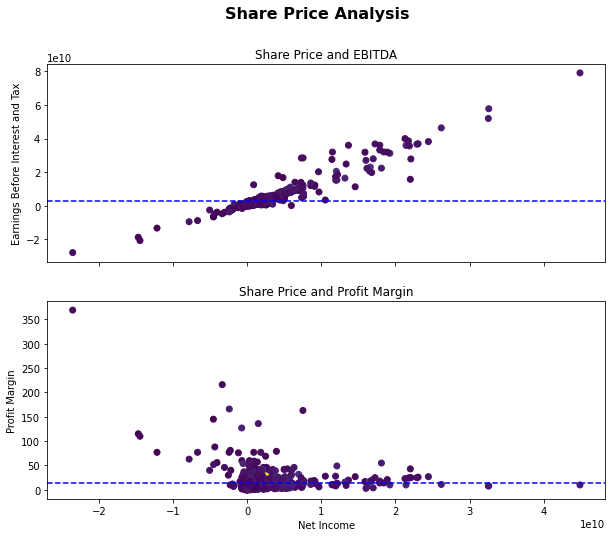

In [88]:
# Setup plot (2 rows, 1 column)
fig, (ax0, ax1) = plt.subplots(nrows=2, # 2 rows
                               ncols=1, 
                               sharex=True, 
                               figsize=(10, 8))

# Add data for ax0
scatter = ax0.scatter(fundamentals["Net Income"], 
                      fundamentals["Earnings Before Interest and Tax"], 
                      c=fundamentals["Target"])
# Customize ax0
ax0.set(title="Share Price and EBITDA",
        ylabel="Earnings Before Interest and Tax")


# Setup a mean line
ax0.axhline(y=fundamentals["Earnings Before Interest and Tax"].mean(), 
            color='b', 
            linestyle='--', 
            label="Average")


# Add data for ax1
scatter = ax1.scatter(fundamentals["Net Income"], 
                      fundamentals["Profit Margin"], 
                      c=fundamentals["Target"])

# Customize ax1
ax1.set(title="Share Price and Profit Margin",
        xlabel="Net Income",
        ylabel="Profit Margin")


# Setup a mean line
ax1.axhline(y=fundamentals["Profit Margin"].mean(), 
            color='b', 
            linestyle='--', 
            label="Average")

# Title the figure
fig.suptitle('Share Price Analysis', fontsize=16, fontweight='bold');

So what we've done above is plot the share prices of all the stocks based on their net income and either profit margin or EBITDA (Earnings before Interest, Tax, Depreciation and Amortization). It's important to note the little 1e10 at the bottom right and top left corners - these earnings are on the order of billions. This is, however, very revealing. Net Income and EBITDA seem very strongly positively correlated, which makes sense - higher income should generally mean higher earnings. This also seems reflected in the stock price. The other graph is very interesting, and reflects the diversity of companies in the dataset. In fact, profit margin seems slightly negatively correlated with net income - perhaps as the income increases, so does the size of the company, and with it operating expenses and other costs, such that even if the absolute earnings rise, the profit margin falls. 

This concludes our data exploration section - we've got a feel for the data, and it doesn't seem like there are any especially erroneous outliers - there are some rather high prices and profit margins, but the NYSE is a very diverse index, and so to remove these unusual companies would leave our model badly equipped to deal with companies that aren't run-of-the-mill, yet these are often the ones where greatest returns are to be made. Hence, I've decided to keep all the data we currently have. Now it is time for us to move onto training our models on this data.

# 4. Training a model

## 4.1. Picking a model

This is a regression problem, but there are many regression algorithms out there. From personal experience, the RandomForestRegressor model seems to perform well in general, so this is one of the models we will test. Bearing in mind we will also need to tune the hyperparameters of these models, it is perhaps unwise to test out too many, so let us narrow it down to three different models to test. To help decide on some ideas, I consulted the SciKit Learn documentation to find their machine learning models map - https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html. Following this, I have decided to also test a Lasso and a RidgeRegression model.

## 4.2. Training a model

We need to split our data into training, validation and test sets first -  a common split is 50:20:30, but given that our dataset isn't particularly big, only 670-ish samples might be a little too small for our model to really learn on. Hence, I've decided to go with a 60:20:20 split, to try and get a better model without having such a small test set that our results are skewed.

In [90]:
# First define X and y
X = fundamentals.drop("Target", axis=1)
y = fundamentals["Target"]
# use train test split once to get two datasets - training and validation, and test
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# apply train test split again to slice up the training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size=0.25, random_state=42)

In [91]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((813, 86), (813,), (272, 86), (272,))

This is great, 813 (train) + 272 (validation) + 272 (test) = 1357, which is how much data we had originally, so we are good to go

Now let us train our models on the training data.

In [126]:
# First instantiate all our models
rfrmodel = RandomForestRegressor(n_jobs=-1, random_state=42)
ridgemodel = Ridge(alpha=1.0)
lassomodel = Lasso(alpha=0.1)

First we try the RandomForestRegressor

In [98]:
rfrmodel.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [99]:
show_scores(rfrmodel, X_train, X_val, y_train, y_val)

{'Training RMSE': 18.18499206227095,
 'Valid RMSE': 59.32392446279848,
 'Training R^2': 0.950506419781094,
 'Valid R^2': 0.6475429814645668}

Now time for the Ridge

In [100]:
ridgemodel.fit(X_train, y_train)

Ridge()

In [101]:
show_scores(ridgemodel, X_train, X_val, y_train, y_val)

{'Training RMSE': 52.63969189956261,
 'Valid RMSE': 291.31715313190045,
 'Training R^2': 0.5852854082998324,
 'Valid R^2': -7.499209434254368}

In [127]:
lassomodel.fit(X_train, y_train)

C:\Users\cpd\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1158914.6364361385, tolerance: 543.2101881228413
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1)

In [128]:
show_scores(lassomodel, X_train, X_val, y_train, y_val)

{'Training RMSE': 53.27524054109613,
 'Valid RMSE': 287.38466938513767,
 'Training R^2': 0.5752107893899153,
 'Valid R^2': -7.271296903747842}

Although I said RMSE would be our evaluation metric, I have included R^2 as well just for visualization purposes - it's easier to interpret than a somewhat arbitrary-seeming number. In this case, it was very useful in highlighting how terribly Ridge and Lasso did - negative R^2 means they would have been better off simply taking the mean of the validation values!

So from these initial tests, RandomForestRegressor is far in the lead. Its RMSE is much lower, and although 64.8% on the validation data isn't an amazing score, the other two models return very negative R^2 values - i.e. they are much worse than just taking the mean. It looks like we will probably focus on the Random Forest Regressor, as it outperforms the others by so much.

# 5. Improving the model

## 5.1. Tuning Hyperparameters of RandomForestRegressor

After doing some research into tuning RandomForestRegressors - such as at https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/ - I decided to adjust the n_estimators, max_depth, min_samples_leaf and max_features hyperparameters of the model. Given that my computer has limited processing power, I will use GridSearchCV (as RandomizedSearchCV might overlook some better combinations of hyperparameters), but with a relatively limited number of hyperparameters. The other advantage of GridSearchCV (which also applies to RandomizedSearchCV) is that the testing is cross-validated, meaning we are unlikely to get anomalously accurate or inaccurate results.

In [138]:
# define a dictionary of the hyperparameters we will tune
rfr_hyperparameters = {
               "n_estimators": np.arange(10, 100, 20),
               "max_depth": [None, 3, 5],
               "min_samples_leaf": np.arange(1, 20, 4),
               "max_features": [1, "sqrt", "auto"],
                }

Let's run GridSearchCV and see what hyperparameters it suggests

In [139]:
grid_search_rfr_model = GridSearchCV(RandomForestRegressor(
                                                    # allow model to use max processing power
                                                    n_jobs=-1,
                                                    # so results are replicable
                                                    random_state=42),
                                                    param_grid=rfr_hyperparameters,
                                                    # cross validate
                                                    cv=3,
                                                    verbose=True)

# Fit the RandomizedSearchCV model
grid_search_rfr_model.fit(X_train, y_train)

Fitting 3 folds for each of 225 candidates, totalling 675 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 675 out of 675 | elapsed:  2.5min finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             param_grid={'max_depth': [None, 3, 5],
                         'max_features': [1, 'sqrt', 'auto'],
                         'min_samples_leaf': array([ 1,  5,  9, 13, 17]),
                         'n_estimators': array([10, 30, 50, 70, 90])},
             verbose=True)

In [140]:
grid_search_rfr_model.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'n_estimators': 50}

So now we have our grid search results, let's test these new hyperparameters and see if they improve our model's performance.

In [141]:
show_scores(grid_search_rfr_model, X_train, X_val, y_train, y_val)

{'Training RMSE': 18.79139896343244,
 'Valid RMSE': 57.91851649432757,
 'Training R^2': 0.947150502134465,
 'Valid R^2': 0.6640448711688354}

So this has slightly improved our model - our valid RMSE is down from 59.3 to 57.9, and our valid R^2 has increased from 0.648 to 0.664. This is still not amazing, however, so let's try again with more hyperparameter options, and see if we can get a better result.

In [142]:
big_hyperparameter_grid = {
               "n_estimators": np.arange(10, 100, 10),
               "max_depth": [None, 3, 5, 10],
               "min_samples_leaf": np.arange(1, 20, 4),
               "max_features": [1, "sqrt", "auto"],
}

In [143]:
big_grid_search_rfr_model = GridSearchCV(RandomForestRegressor(
                                                    # allow model to use max processing power
                                                    n_jobs=-1,
                                                    # so results are replicable
                                                    random_state=42),
                                                    param_grid=big_hyperparameter_grid,
                                                    # cross validate
                                                    cv=3,
                                                    verbose=True)

# Fit the RandomizedSearchCV model
big_grid_search_rfr_model.fit(X_train, y_train)
show_scores(big_grid_search_rfr_model, X_train, X_val, y_train, y_val)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  6.3min finished


{'Training RMSE': 18.791398963432435,
 'Valid RMSE': 57.91851649432757,
 'Training R^2': 0.947150502134465,
 'Valid R^2': 0.6640448711688354}

In [144]:
big_grid_search_rfr_model.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'n_estimators': 50}

So it turns out we had the best hyperparameters all along anyway. We could keep experimenting, but we only have so much processing power, and this could start to take a very long time to run each experiment. Hence, let's take a look at the other models.

In [168]:
best_model = RandomForestRegressor(max_depth=None, max_features="auto", min_samples_leaf=1, n_estimators=50)
best_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50)

## 5.2. Tuning Hyperparameters of Lasso

After doing similar research - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html - I decided to adjust the alpha, max_iter and tol hyperparameters of this model. We will again be using GridSearchCV, to ensure we don't miss an ideal combination of hyperparameters

In [151]:
lasso_hyperparameters_grid = {
               "alpha": np.arange(0.5, 1.5, 0.1),
               "max_iter": np.arange(1000, 50000, 5000),
               "tol": np.logspace(0.0001, 0.1, 50)
}

In [150]:
grid_search_lasso_model = GridSearchCV(Lasso(
                                            # so results are replicable
                                            random_state=42),
                                            param_grid=lasso_hyperparameters_grid,
                                            # cross validate
                                            cv=3,
                                            verbose=True)

# Fit the RandomizedSearchCV model
grid_search_lasso_model.fit(X_train, y_train)
show_scores(grid_search_lasso_model, X_train, X_val, y_train, y_val)

Fitting 3 folds for each of 5000 candidates, totalling 15000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 15000 out of 15000 | elapsed:  6.2min finished


{'Training RMSE': 67.19846256317236,
 'Valid RMSE': 226.38200451019594,
 'Training R^2': 0.3241640140824903,
 'Valid R^2': -4.132514900256035}

Unfortunately, despite trying many different hyperparameters, Lasso regression is still performing extremely poorly - its valid RMSE is nearly 4x as large as that of the Random Forest. It seems like this model is unlikely to be good enough to make valuable and consistent predictions, so we will be abandoning it from now on.

## 5.3. Tuning hyperparameters of RidgeRegression

Having researched the RidgeRegression hyperparameters at https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html, I realized that Ridge Regression and Lasso are somewhat similar, as are their hyperparameters. Given that the Ridge and Lasso performed similarly badly on the initial data, and even after tuning Lasso's hyperparameters it was still far worse than the Random Forest Regressor, I decided to abandon the Ridge and Lasso models, and instead test the Random Forest Regressor.

# 6. Evaluating the models

## 6.1. What metrics to use?

Investigating regression metrics - https://aiaspirant.com/regression-evaluation-metrics/ and https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b - showed me that there are many different metrics for judging the success of a model. Although R^2 error is commonly used, the articles I read seemed to suggest that the issue with it is that more independent variables taken into account can reduce your R^2 error, even if those variables turn out to be completely irrelevant to the result. We have quite a lot of independent variables here, and so R^2 might give spuriously good results. Hence, I have decided to use Root Mean Squared Error as my evaluation metric for this project - I will be trying to minimize it.

## 6.2. Testing the various models based on this evaluation metric

Now that we have tuned our models into (hopefully) their ideal possible forms for this project, let's let each of them try and predict on the test data, and then see how well they did according to our validation metric of Root Mean Squared Error (and take a look at the R^2 for some additional context)

In [169]:
test_predictions = best_model.predict(X_test)

In [170]:
mean_squared_error(test_predictions, y_test, squared=False)

37.08519571218125

In [171]:
r2_score(test_predictions, y_test)

0.20173014896732921

# 7. Feature Importance

We have now established that the Random Forest Regression model worked the best, and should probably be used for our future predictions. However, it is probably useful to know which of the features mattered most in this data, so that for future projects of a similar nature we can ensure that we get the best quality data on those features, and perhaps ignore some of the less relevant features to save time and processing power, and prevent our model finding spurious patterns in data that was actually irrelevant.

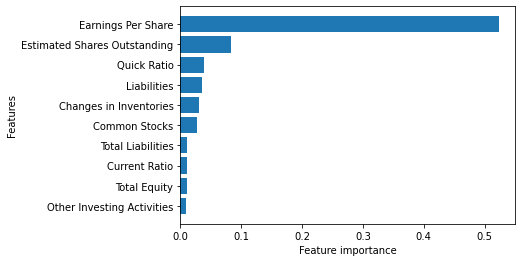

In [172]:
plot_features(X_train.columns, best_model.feature_importances_)

So this is very interesting to observe. Earnings Per Share is an important feature, but I did not expect it to be far and away so much more significant than everything else. It is interesting that things like profit margin and gross profit feature nowhere on this list, whereas things that might have seemed less important like the estimated shares outstanding are actually incredibly significant. This is valuable information for a financial analyst, and important to bear in mind for future projects - perhaps these attributes of the data should be given greater weightage next time.

# 8. Conclusion

So, over the course of this project, we investigated three different models for predicting stock price based on fundamental information about the stock. It transpired in the end that Ridge Regression and Lasso Regression did not work very well on this problem, and were far outcompeted by the Random Forest Regressor. Even this model was far from perfect - on average, it was about 37 dollars off the true price of the stock, which, in a market where most of the stocks are between 1 and 200 dollars, is rather high. However, we were using Root *Mean* Squared Error, so it is plausible that the model had a larger absolute error for some expensive stocks, and this distorted the average error as well. Overall, this was reasonably successful, but there are several steps we could take to improve this predictor.

**1. Get more data:** At the end of the day, the model was only trained on about 800 samples, which, by the standards of machine learning models, is on the small side. Especially for a commercial operation like an investment bank, it is likely there would be far more samples for our model to train on, which would hopefully significantly increase its accuracy and reduce its error.

**2. Tune more hyperparameters:** I was running this project on my own computer, whose processing capabilities are fairly limited. If we wanted to make this a properly deployable model, we could perhaps enlist the use of a much more powerful computer, perhaps one with a GPU, or use a Google Colab notebook. These would allow us to perform significantly more calculations, and tune many more hyperparameter combinations, hopefully ultimately resulting in a better model.

**3. Try out some other models:** In this project, we only tested 3 models, all of which are on the Sci Kit Learn Map. However, there are dozens, if not hundreds, of different regression models out there, and very probably some that would outperform our Random Forest on this specific problem. This would be worth investigating with the help of a finance professional, whose background would enable them to better advise us on what types of models tend to work better on financial data, or whether there are certain data parameters we should have told our model to focus on more.

**4. Try to combine our model with others:** We have built one model here, but there are many approaches to analyzing stocks. It would definitely be worth trying to include elements of other analysis in our model. For example, we ignored a lot of the prices dataset, choosing only to pick the prices on the specific dates that mattered to us. However, we could have included the rest of the data too, so that our model could hopefully learn about how past prices tend to influence future ones, and how markets can move in trends and cycles. This would likely further improve our model.

Overall, however, this was a relatively successful project. We instantiated and tested multiple models, and came up with a model that functions somewhat well. Given the sizable constraints on processing power and training data, the model performed well, and it is likely that the slightly high RMSE is due to the errors on predicting expensive stocks skewing the average. The other thing that is important to remember is simply how unpredictable the stock market is. Even with access to nearly unlimited computing power, vast quantities of data, deep knowledge about the field and much more advanced algorithms and models, the professionals of the finance industry still have not learnt to "beat the market". In fact, they quite frequently get it wrong, spectacularly so on occasion. In light of this, despite its clear flaws, our model can be said to have acquitted itself well, and so I feel this project was a success.